Original Opensees Example Link: https://opensees.berkeley.edu/wiki/index.php/OpenSees_Example_4._Portal_Frame

<img src="https://opensees.berkeley.edu/wiki/images/e/e0/Example4_figure1.GIF" align="left"></img>
<img src="https://opensees.berkeley.edu/wiki/images/5/59/Example1b_Push.GIF" align="right"></img>

In [1]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt
import math

## Units Conversion

In [36]:
#length conversion
m = 1.0
cm = 100*m # centimeter, needed for displacement input in MultipleSupport excitation
inch = m/39.37
ft = 12.*inch 

#area conversion
sqinch = inch**2
inch4 = inch**4

#ksi to pa
pa = 1.0
kpa = 1000*pa
ksi = 6.89*1000*kpa  #ksi = kip / sqinch
psi = ksi/1000.


#kip to kN
N = 1.0
kN = 1000 * N
kip = 4.45 * kN

# pound to kg
kg = 1 
pound = 0.453592 * kg
lbf = psi*inch**2  #pounds force
pcf = lbf/math.pow(ft, 3) #pounds per cubic foot
psf = lbf/math.pow(ft, 2) #pounds per square foot


# acceleration due to gravity
g = 9.81 #m/s^2

#time
sec = 1.0


## Model Varibles for Elastic Element Section

In [3]:
#refrences taken from elastic model in original example 
sectionType = 'elastic'  #this analysis uses elastic section of beam and column

#Structure Geometry
LCol = 36.*ft		# column length
LBeam = 42.*ft		# beam length
Weight = 4000.*kip		# superstructure weight #total imposed load on the beam in kN or Kip


#section general geometry
HCol = 5.*ft #depth of column
BCol = 4.*ft #width of column
HBeam = 8.*ft #depth of beam
BBeam = 5.*ft #width of beam

# calculated parameters
PCol = Weight/2 #nodal dead weight per column
Mass = PCol/g #nodal mass
MCol = 1./12.* (Weight/LBeam) *math.pow(LBeam,2)	# beam-end moment due to distributed load.        #wl^2/12


#calculated geometry parameters
ACol = BCol * HCol
ABeam = BBeam * HBeam
IzCol = 1./12. * BCol * math.pow(HCol, 3)
IzBeam = 1./12. * BBeam * math.pow(HBeam, 3)

## Model Functions

In [4]:
def getModel():
    ops.wipe()
    ops.model("BasicBuilder", '-ndm', 2, '-ndf', 3)

    #nodes definition
    xcor = [0, LBeam]
    ycor = [0, LCol]
    for j,y in enumerate(ycor):
        for i,x in enumerate(xcor):
            ops.node(j*len(xcor)+i + 1, *[x,y])
    
    #fixity definition
    ops.fixY(0, *[1,1,1]) #fix all nodes with ycoordinate = 0 (so fixing both node 1 and 2: base nodes)

    # nodal masses:
    ops.mass(3, *[Mass, 0., 0.])	# node#, Mx My Mz, Mass=Weight/g, neglect rotational inertia at nodes
    ops.mass(4, *[Mass, 0., 0.])
    

In [5]:
def getSections():
    #geometric transformation define
    #performs a linear geometric transformation of beam stiffness and resisting force from the basic system to the global-coordinate system
    #it is better practice to keep separate transf tags for beams and columns
    colTransfTag = 1
    beamTransfTag = 2
    colTransfType = 'Linear'  #making this variable to help easy change of linear to pdelta, as only column have pdelta effects
    ops.geomTransf(colTransfType, colTransfTag)
    ops.geomTransf('Linear', beamTransfTag)
    

    #material properties
    fc = -4. * ksi # CONCRETE Compressive Strength (+Tension, -Compression)
    Ec = 57 * ksi * math.sqrt(-fc/psi) # Concrete Elastic Modulus
    
    #element define
    #element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag, <'-mass', mass>, <'-cMass'>, <'-release', releaseCode>)
    ops.element('elasticBeamColumn', 1, *[1,3], ACol, Ec, IzCol, colTransfTag) #col
    ops.element('elasticBeamColumn', 2, *[2,4], ACol, Ec, IzCol, colTransfTag)#col
    ops.element('elasticBeamColumn', 3, *[3,4], ABeam, Ec, IzBeam, beamTransfTag) #beam

## Recorder Functions

In [6]:
def getRecorders(SectionType, AnalyisName):
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}_DispFree.txt", 
                 '-time', '-closeOnWrite', '-node', *[3,4],'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}_DispSupport.txt", 
                 '-time', '-closeOnWrite', '-node', *[1,2],'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}_ReactionsSupport.txt", 
                 '-time', '-closeOnWrite', '-node', *[1,2],'-dof', *[1,2,3], 'reaction')

    #drift recorder: but throws error in openseespy
    #ops.recorder("drift", '-file', f"Outputs/{SectionType}/{AnalyisName}_Drift.txt", '-time', '-closeOnWrite', '-inode', *[1,2],'-jnode', *[3,4], '-dof', 1, '-perpDirn', 2)
    
    #recorder Element -file Data/FCol.out -time -ele 1 force
    ops.recorder('Element', '-file', f'Outputs/{SectionType}/{AnalyisName}_ForcesColumn.txt', 
                 '-time', '-closeOnWrite', '-ele', *[1,2], 'globalForce')
    ops.recorder('Element', '-file', f'Outputs/{SectionType}/{AnalyisName}_ForcesBeam.txt', 
                 '-time', '-closeOnWrite', '-ele', 3, 'globalForce')				# Column section forces, axial and moment, node i


## Analysis Functions

In [40]:
linTS = 1 #linear time series tag
sineSeries = 2 #uniform excitation tag

### Gravity Analysis

In [38]:
## Analysis Definitions
def runGravityAnalysis():
    udlBeam = Weight/LBeam
    #gravity loads
    ops.timeSeries('Linear', linTS)
    ops.pattern('Plain', 100, linTS) #patterntype #patterntag #timeseries tag
    ops.eleLoad('-ele', 3, '-type', '-beamUniform', -1* udlBeam)


    #setting gravity analysis parameters and functions
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    
    tol = 1.0e-8
    numIter = 6
    ops.test('NormDispIncr', tol, numIter) #test NormDispIncr $tol $iter <$pFlag> <$nType>
    ops.algorithm('Newton')

    NStepGravity = 10
    DGravity = 1.0 / NStepGravity
    ops.integrator('LoadControl', DGravity)
    ops.analysis('Static')

    ops.record() #to force recorder to record initial state of the model regarding gravity loads
    ops.analyze(NStepGravity)

### Static Pushover

In [39]:
def runStaticPushover():
    #since static pushover is performed after gravity analysis--- set gravity load constant and time to 0
    ops.loadConst('-time', 0)
    
    #structure parameters
    ControlNode = 3
    ControlNodeDof = 1
    
    #analysis parameters
    Dmax = .1*LCol # maximum displacement of pushover. push to 10% drift.
    Dincr = 0.001*LCol  #increment in displacement for pushover
    NStepPushover = int(Dmax/Dincr)
    
    #incase we want to change test type due to convergence failure
    testTypeStatic = 'EnergyIncr'
    algorithmTypeStatic = 'Newton'
    
    tolStatic = 1.0e-8   
    maxNumIterStatic = 6
    maxNumIterConvergeStatic = 2000 # for improved-convergence procedure
    
    # define the lateral load as a proportion of the weight so that the pseudo time equals the lateral-load coefficient when using linear load pattern
    Hload = Weight/2
    ops.pattern('Plain', 200, linTS) #patterntype #patterntag #timeseries tag
    ops.load(3, *[Hload, 0., 0.])
    ops.load(4, *[Hload, 0., 0.])
    
    #setting gravity analysis parameters and functions
    ops.constraints('Plain')
    ops.numberer('RCM')
    ops.system('BandGeneral')
    
    ops.test(testTypeStatic, tolStatic, maxNumIterStatic) #test NormDispIncr $tol $iter <$pFlag> <$nType>
    ops.algorithm(algorithmTypeStatic)
    
    NStepGravity = 10
    DGravity = 1.0 / NStepGravity
    ops.integrator('DisplacementControl', ControlNode, ControlNodeDof, Dincr)
    ops.analysis('Static')

    ops.record() #to force recorder to record initial state of the model regarding gravity loads
    status = ops.analyze(NStepPushover)

    #handling well if the analysis fails:
    if status != 0:
        print("Analysis Failed ! Trying other methods ...")
        DStep = 0
        ok = 0
        while DStep<=1 & status==0:
            ControlDisp = ops.nodeDisp(ControlNode, ControlNodeDof)
            DStep = ControlDisp / Dmax
            status = ops.analyze(1)

            if status != 0:
                print("Trying Newton with Initial Tangent")
                ops.test('NormDispIncr', tol, 2000)
                ops.algorithm('Newton', '-initial')
                status = ops.analyze(1)
                ops.test(testTypeStatic, tolStatic, maxNumIterStatic)
                
            if status !=0:
                print("Trying Bryoden")
                ops.algorithm('Bryoden', 8)
                status = ops.analyze(1)
                ops.algorithm(algorithmTypeStatic)
                
            if status !=0:
                print("Trying Newton with Line Search")
                ops.algorithm('NewtonLineSearch', 0.8)
                status = ops.analyze(1)
                ops.algorithm(algorithmTypeStatic)
    if status != 0:
        print(f"Problem! Pushover Analysis\t Node={ControlNode}, Dof={ControlNodeDof}, Disp={ops.nodeDisp(ControlNode, ControlNodeDof)}")
    else:
        print(f"Success! Pushover Analysis\t Node={ControlNode}, Dof={ControlNodeDof}, Disp={ops.nodeDisp(ControlNode, ControlNodeDof)}")

### Dynamic Uniform Sinewave ground motion

In [43]:


# set up ground motion analysis parameters
DtAnalysis = 0.01*sec
TmaxAnalysis = 10.*sec

#some other dynamic analysis variables
algorithmTypeDynamic = 'ModifiedNewton'
integratorTypeDynamic = 'Newmark'
NewmarkGamma = 0.5
NewmarkBeta = 0.25

testTypeDynamic = 'EnergyIncr'
tolDynamic = 1.0e-8
maxNumIterDynamic = 10
maxNumIterConvergeDynamic = 2000


def runUniformSineWaveGM():
    ops.loadConst('-time', 0)
    
    ops.constraints('Transformation')
    ops.numberer('RCM')
    ops.system('BandGeneral')
    ops.test(testTypeDynamic, tolDynamic, maxNumIterDynamic)
    ops.algorithm(algorithmTypeDynamic)
    ops.integrator(integratorTypeDynamic, NewmarkGamma, NewmarkBeta)
    ops.analysis('Transient')
    
    # define Rayleigh Damping
    xDamp = 0.2  #2% damping ratio
    lambda_ = ops.eigen(1)
    omega = math.pow(lambda_[0], 0.5)
    alphaM = 0.
    betaKcurr = 0.
    betaKcomm = 2.*xDamp/omega
    betaKinit = 0.
    ops.rayleigh(alphaM, betaKcurr, betaKinit, betaKcomm)  #rayleigh damping
    
    #perform dynamic ground motion analysis
    # Uniform Sine-Wave ground motion (uniform acceleration input at all support nodes)
    GMdirection = 1
    GMSineAccAmpl = 0.5*g
    TPeriodSine = .35*sec
    DurationSine = 3.0*sec
    #pattern('UniformExcitation', patternTag, dir, '-disp', dispSeriesTag, '-vel', velSeriesTag, '-accel', accelSeriesTag, '-vel0', vel0, '-fact', fact)
    patternTag = 400
    DtGround = 0.005*sec
    omegaSine = 2*np.pi/TPeriodSine
    vel0 = GMSineAccAmpl*(-1)/omegaSine
    ops.timeSeries('Trig',sineSeries, 0, DurationSine, TPeriodSine, '-factor', GMSineAccAmpl)
    ops.pattern('UniformExcitation', patternTag, GMdirection, '-accel', sineSeries, '-vel0', vel0)

    Nsteps = int(TmaxAnalysis/DtAnalysis)
    status = ops.analyze(Nsteps, DtAnalysis)
    
    
    
    
    


In [44]:
getModel()
getSections()
getRecorders('elastic', 'Gravity')
runGravityAnalysis()

<Axes: >

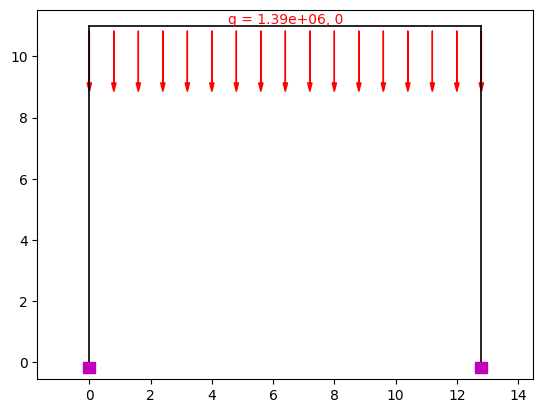

In [45]:
ovs.plot_loads_2d()

In [46]:
Weight / LBeam / 2

695224.2063492063

In [47]:
getModel()
getSections()
runGravityAnalysis()
getRecorders('elastic', 'Uniform_Sine_GM')
runUniformSineWaveGM()



WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis
WARNING analysis Transient - no Integrator specified, 
 TransientIntegrator default will be used


160.69381044512602

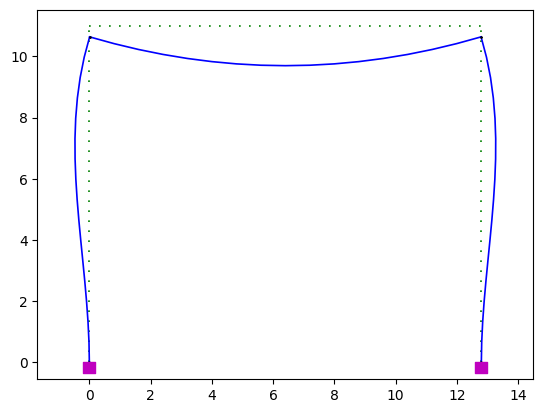

In [48]:
ovs.plot_defo()

In [23]:
disps = np.loadtxt("Outputs/elastic/Pushover_DispFree.txt")
forces = np.loadtxt("Outputs/elastic/Pushover_ReactionsSupport.txt")

In [30]:
disp4 = disps[:, 4:] #displacement at node 4
shear2 = forces[:, 4:]

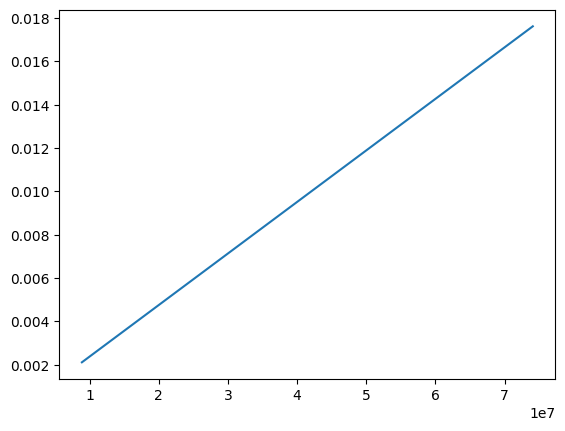

In [33]:
plt.plot(shear2[:,1], -disp4[:, 1])